In [64]:
# unresolved username ownership
# poopdwogga


In [ ]:
def load_txt(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

cpvp_lt_mct_data = load_txt("result_data/cpvp_lt_mct.txt")
cpvp_mct_data    = load_txt("result_data/cpvp_mct.txt")

mace_mct_data    = load_txt("result_data/mace_mct.txt")

uhc_mct_data     = load_txt("result_data/uhc_mct.txt")
uhc_pvpt_data    = load_txt("result_data/uhc_pvpt.txt")

axe_mct_data     = load_txt("result_data/axe_mct.txt")

smp_mct_data     = load_txt("result_data/smp_mct.txt")
smp_pvpt_data    = load_txt("result_data/smp_pvpt.txt")

data = (cpvp_lt_mct_data + cpvp_mct_data)
#data = mace_mct_data
#data = (uhc_pvpt_data + uhc_mct_data)

In [66]:
import re

data = data.lower().strip()
data = re.sub("won", "", data)
data = re.sub("lost", "", data)
data = "\n".join([s for s in data.split("\n") if s]) # remove empty lines
data = "\n".join([s for s in data.split("\n") if not (s.__contains__("strikes") or s.__contains__("fight") or s.__contains__("eval"))]) # Remove lines that contain fight information like "HT3 Fights:" or "LT1 Fights"
data = "\n".join([s for s in data.split("\n") if not (s.__contains__("evaluation"))]) # Remove lines that say "passed evaluation"
data = re.sub(r"^@[^-]+-\s*([^-]+)\s*-.*$", r"\1", data, flags=re.MULTILINE) # removes the discord username and the promotion / demotion message and leaves only the username: "@marlow - marlowww - placed back high tier 1" => "marlowww"

lines = data.split("\n") # remove the authors of each discord message from the string
data = "\n".join(
    line for i, line in enumerate(lines)
    if not (i + 1 < len(lines) and lines[i + 1].strip() == "—")
)

#print(data)

In [67]:
from datetime import datetime

# Turn the string into an array of messages, where each message is itself an array that contains each individual line
messages = [
    [line.strip() for line in message.strip().split("\n") if line.strip()]
    for message in data.split("—") if message.strip()
]

# Define a function to extract and parse the date from the first line of each message
def parse_date(message):
    date_str = message[0].split(",")[0].strip() + "," + message[0].split(",")[1]
    return datetime.strptime(date_str, "%d/%m/%Y, %H:%M")

# Sort the messages in ascending order by date
messages.sort(key=parse_date)

# Keep first two entries fixed, reverse everything after
for i, m in enumerate(messages):
    if len(m) > 2:
        messages[i] = m[:2] + m[2:][::-1]

# Debug print
for m in messages:
    print(m)
#print(messages)

['29/06/2024, 12:27', 'usergogo', '3-0 gianslimer', '3-0 serexus', '3-0 clompyyy', '3-1 osilasghg']
['04/07/2024, 21:58', 'gabsless', '3-2 datonearcticfox', '3-0 leopoldus', '3-0 chocoaardbei', '3-0 osilasghg']
['17/07/2024, 18:22', 'gabsless', '4-2 usergogo']
['19/07/2024, 15:19', 'captain_c08', '3-0 jsputer', '3-1 vlomists', '3-0 sosmin', '3-0 wolff1x', '3-0 osilasghg']
['27/07/2024, 18:23', 'datonearcticfox', '3-0 currut', '3-1 melaa', '3-2 noctys_ira', '3-2 stormdysonb']
['29/07/2024, 23:27', 'macepvper', '3-0 ghoxt', '3-1 flowtives', '3-0 perubian', '3-1 crystalpvpnn']
['31/07/2024, 03:14', 'blubbie_', '3-1 crystalpvpnn', '0-3 macepvper']
['31/07/2024, 12:36', 'darkeven_79', '3-0 aroxi', '3-0 armen', '3-1 lyne', '3-0 stormdysonb']
['31/07/2024, 16:01', 'vyyi', '2-3 datonearcticfox']
['31/07/2024, 23:17', 'khalihmortimer', '2-3 macepvper']
['01/08/2024, 12:06', 'lilaxollly', '3-0 macepvper']
['01/08/2024, 13:15', 'jamy1111', '3-2 macepvper']
['01/08/2024, 20:20', 'clomp_', '3-2 lil

In [68]:
allplayers = set()

for result in messages:
  if len(result) <= 1:
    print(result)
  else:
    allplayers.add(result[1])
  for match in result[2:]:
    allplayers.add(match[4:])

print(allplayers)
print(len(allplayers))

['07/02/2025, 22:48']
['11/03/2025, 20:34']
['18/03/2025, 17:31']
['22/04/2025, 03:15']
['27/07/2025, 22:55']
{'', 'str8outtashqelon', 'guramigson', 'doorblesito', 'melaa', 'flametex', 'flowtives', 'chantepleur', 'sntp (ff at 0-0)', 'ihmortimer', 'osilasghg', 'cutewife', 'holonpvpastive', 'leopoldus', 'ospree14', 'peaceclown', 'enderrlol', 'coped_', 'turbinial', '__alexx', 'viruslmao', 'failed ht3', 'rappture', 'incongruity', 'alexoinks', 'boikicrus', 'esf_verxcy', 'stunslammer', "ht 4 ht3s due to the lack of avaliable lt2's at the time of the test.", 'aroxi', 'ht 3 ht3’s due to the lack of available lt2’s at the time of the test.', 'pppanpawal', ' macepvper', 'clovers_son', 'sosmin', 'jsputer', 'ging for lt2', 'imnotrash', 'macepvper', 'turtiled', 'audaciety', 'caffeinena', 'enchantersky', 'jxydon', 'chocoaardbei', 'thelionmcyt', 'elmeriizz', 'rikb100', ' lilaxollly', 'realtii', 'jmoment', 'sheep55555', '16elwells', 'blue', 'doorble', 'vimtove', 'armen', 'inial', 'x_kyran_x', 'xtki4le

In [ ]:
from datetime import datetime, timedelta
from collections import deque
from typing import Dict, List, Tuple

FT4_GM = True

DEFAULT_ELO = 2000
K = 70 if FT4_GM else 100
DATE_FORMAT = "%d/%m/%Y, %H:%M"
DUPLICATE_WINDOW = timedelta(days=300)
COUNT_INDIVIDUAL_ROUNDS = False
BASE_WEIGHT = 0.1
ITERATION_COUNT = 10
RESET_DIVISOR = 1.8


# --- ELO helpers --------------------------------------------------------

def expected_score(r1: float, r2: float) -> float:
    return 1 / (1 + 10 ** ((r2 - r1) / 400))


def update_elo(r1: float, r2: float, score: float) -> Tuple[float, float]:
    e1 = expected_score(r1, r2)
    e2 = expected_score(r2, r1)
    return r1 + K * (score - e1), r2 + K * ((1 - score) - e2)


def parse_match_result(result: str) -> Tuple[str, int, int]:
    """Parse '4-2 opponent' → ('opponent', 4, 2)"""
    parts = result.strip().split()
    if len(parts) < 2 or '-' not in parts[0]:
        return None, 0, 0
    try:
        wins, losses = map(int, parts[0].split('-'))
        return parts[1].lower(), wins, losses
    except:
        return None, 0, 0


# --- Main processing ----------------------------------------------------

def process_messages(messages: List[List[str]]) -> Dict[str, dict]:

    players: Dict[str, dict] = {}

    # Pre-parse all dates once (major performance boost)
    processed_msgs = []
    for entry in messages:
        if len(entry) < 2:
            continue
        date = datetime.strptime(entry[0], DATE_FORMAT)
        player = entry[1].lower()
        processed_msgs.append((date, player, entry[2:]))

    # Duplicate tracking
    recent_matches = deque()
    duplicate_set = set()

    for _ in range(ITERATION_COUNT):

        # Reset duplicates per iteration
        recent_matches.clear()
        duplicate_set.clear()

        # Reset players soft-elo and history
        for name, data in players.items():
            data["history"].clear()

            if data["elo"] > DEFAULT_ELO:
                data["elo"] = DEFAULT_ELO + (data["elo"] - DEFAULT_ELO) / RESET_DIVISOR
            else:
                data["elo"] = data["elo"]

            data["peak"] = data["elo"]


        # Process each message
        for date, player, match_list in processed_msgs:

            if player not in players:
                players[player] = {"elo": DEFAULT_ELO, "peak": DEFAULT_ELO, "history": []}

            players[player]["history"].append((date, players[player]["elo"]))

            # Clean out old matches (O(1) amortized)
            while recent_matches and date - recent_matches[0][0] > DUPLICATE_WINDOW:
                old = recent_matches.popleft()
                key = (old[1], old[2], old[3], old[4])
                rev = (old[1], old[2], old[4], old[3])
                duplicate_set.discard(key)
                duplicate_set.discard(rev)

            for raw_match in match_list:

                opponent, wins, losses = parse_match_result(raw_match)
                if not opponent:
                    continue

                if opponent not in players:
                    players[opponent] = {"elo": DEFAULT_ELO, "peak": DEFAULT_ELO, "history": []}

                players[opponent]["history"].append((date, players[opponent]["elo"]))

                # Determine sorted pair
                p1, p2 = sorted([player, opponent])
                key = (p1, p2, wins, losses)
                rev = (p1, p2, losses, wins)

                # Duplicate detection in O(1)
                if key in duplicate_set or rev in duplicate_set:
                    continue

                # Store in the recent deque + set
                recent_matches.append((date, p1, p2, wins, losses))
                duplicate_set.add(key)
                duplicate_set.add(rev)

                # --- ELO Update ------------------------------------------------
                r1, r2 = players[player]["elo"], players[opponent]["elo"]

                if COUNT_INDIVIDUAL_ROUNDS:
                    for _ in range(wins):
                        r1, r2 = update_elo(r1, r2, 1)
                    for _ in range(losses):
                        r1, r2 = update_elo(r1, r2, 0)

                else:
                    total = wins + losses
                    if total == 0:
                        score = 0.5
                    else:
                        ratio = wins / total
                        if wins > losses:
                            score = BASE_WEIGHT + (1 - BASE_WEIGHT) * ratio
                        elif losses > wins:
                            score = (1 - BASE_WEIGHT) * ratio
                        else:
                            score = 0.5

                    r1, r2 = update_elo(r1, r2, score)

                # Apply results
                players[player]["elo"] = r1
                players[opponent]["elo"] = r2

                players[player]["peak"] = max(players[player]["peak"], r1)
                players[opponent]["peak"] = max(players[opponent]["peak"], r2)

                players[player]["history"].append((date, r1))
                players[opponent]["history"].append((date, r2))

    return players


In [70]:
from datetime import datetime, timedelta
from typing import Dict

def print_leaderboard(
    players: Dict[str, dict],
    sort_by: str = "elo",
    top_n: int = 100000,
    inclTier: bool = False,
    active_within_days: int = None,
    up_to_date: str = None,
):
    """
    Prints the ELO leaderboard.

    - up_to_date: optional string in DATE_FORMAT (e.g. "15/07/2025, 00:00").
                 If provided, the leaderboard will be a snapshot "as of" that datetime.
    - active_within_days: if provided, filters players who have not played within the
                 last `active_within_days` days relative to the snapshot (or now if no snapshot).
    - sort_by: "elo" or "peak" (or any key present in the player snapshot dict).
    """
    now = datetime.now()
    cutoff = None
    if up_to_date:
        cutoff = datetime.strptime(up_to_date, DATE_FORMAT)

    filtered_players = {}

    for name, data in players.items():
        history = data.get("history", [])
        if not history:
            # No history at all -> skip (no known rating)
            continue

        # Build a snapshot for this player either up to cutoff or the full current data
        if cutoff:
            # Keep only last ELO per datetime
            history_by_time = {}
            for d, e in history:
                history_by_time[d] = e  # later entries overwrite earlier ones at same timestamp

            # only include timestamps <= cutoff
            past_entries = [(d, e) for d, e in history_by_time.items() if d <= cutoff]
            if not past_entries:
                continue

            # latest entry
            latest_date, latest_elo = max(past_entries, key=lambda x: x[0])

            # peak up to that point
            peak_up_to = max(e for _, e in past_entries)

            player_snapshot = {
                "elo": latest_elo,
                "peak": peak_up_to,
                "history": past_entries,
            }
            # time reference for active-within calculation is the cutoff
            activity_reference = cutoff
        else:
            # use current data as-is
            player_snapshot = {
                "elo": data.get("elo", DEFAULT_ELO),
                "peak": data.get("peak", DEFAULT_ELO),
                "history": history,
            }
            activity_reference = now

        # Apply active_within_days relative to activity_reference (cutoff or now)
        if active_within_days is not None and player_snapshot.get("history"):
            last_match_date = max(date for date, _ in player_snapshot["history"])
            if (activity_reference - last_match_date) > timedelta(days=active_within_days):
                continue  # inactive relative to reference

        filtered_players[name] = player_snapshot

    # Ensure sort_by exists in snapshot, fallback to 'elo'
    def sort_key(item):
        _, pdata = item
        return pdata.get(sort_by, pdata.get("elo", DEFAULT_ELO))

    sorted_players = sorted(filtered_players.items(), key=sort_key, reverse=True)

    # Print header (show cutoff if present)
    header_date = f" (as of {cutoff.strftime(DATE_FORMAT)})" if cutoff else ""
    print(f"\nLeaderboard{header_date}")
    print(f"{'Rank':<5}{'Player':<20}{'ELO':>8}{'Peak':>8}{'Tier':>8}{'PeakTier':>10}")
    print("-" * 65)

    # helper for tier
    def tier_for(elo_val):
        if elo_val > 2500: return "HT1"
        if elo_val > 2350: return "LT1"
        if elo_val > 2250: return "HT2"
        if elo_val > 2100: return "LT2"
        return "HT3"

    for i, (name, pdata) in enumerate(sorted_players[:top_n], start=1):
        elo = pdata["elo"]
        peak = pdata["peak"]
        if inclTier:
            tier = tier_for(elo)
            peak_tier = tier_for(peak)
            print(f"{i:<5}{name:<20}{elo:>8.0f}{peak:>8.0f}{tier:>8}{peak_tier:>10}")
        else:
            if (sort_by == "peak"):
                print(f"{i:<5}{name:<20}{peak:>8.0f}")
            else:
                print(f"{i:<5}{name:<20}{elo:>8.0f}{peak:>8.0f}")


In [71]:
players = process_messages(messages)

In [72]:
#print_leaderboard(players, sort_by="elo", up_to_date="01/09/2024, 00:00", active_within_days=120, inclTier=True)
#print_leaderboard(players, sort_by="peak", active_within_days=None, inclTier=False)
print_leaderboard(players, sort_by="elo", active_within_days=40, inclTier=False)

#for player, data in players.items():
   #if player=="gallerywalk" or player=="dwggo":
      #print(player)
      #print(data["history"])
      #for a in data["history"]:  # last 5 entries
         #print(a)



Leaderboard
Rank Player                   ELO    Peak    Tier  PeakTier
-----------------------------------------------------------------
1    rappture                2291    2291
2    alienoverdose           2259    2299
3    marlowww                2190    2239
4    elmeriizz               2184    2220
5    coldified               2156    2166
6    puffierz                2139    2165
7    chompza                 2136    2136
8    turbinial               2117    2148
9    realtii                 2078    2078
10   villegasjaime           2058    2169
11   chrolphyte              2054    2094
12   ospree14                2051    2060
13   sheep55555              2049    2049
14   itzrealme               2048    2099
15   coped_                  2033    2084
16   caffeinena              2033    2033
17   _mythicc                2028    2028
18   wiskid07                2027    2040
19   firefountain110         2025    2030
20   jmoment                 2008    2008
21   aqtyy67         

In [ ]:
import requests
import time

url = "https://mctiers.com/api/tier/vanilla?count=50&from="

lt3, ht3, lt2, ht2, lt1, ht1 = [], [], [], [], [], []

def safe_get_json(url):
    """Fetch JSON safely. Return None if it fails."""
    try:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"[ERROR] Status {response.status_code} for: {url}")
            return None

        return response.json()  # might still fail
    except Exception as e:
        print(f"[ERROR] JSON decode failed for: {url}")
        return None


for i in range(160):
    full_url = f"{url}{50*i}"
    print(f"Fetching page {i}...")

    rankings = safe_get_json(full_url)

    if rankings is None:  # skip failed pages
        continue

    # Process the data
    for tierindex in range(3):  # 0 = T1, 1 = T2, 2 = T3
        tier_players = rankings["rankings"][tierindex]

        for playerranking in tier_players:
            playeruuid = playerranking[0]
            pos = playerranking[1]  # 0=high, 1=low

            playername = rankings["players"][playeruuid]["name"].lower()
            print("  ", playername)

            # Classification logic
            if tierindex == 0:
                (ht1 if pos == 0 else lt1).append(playername)
            elif tierindex == 1:
                (ht2 if pos == 0 else lt2).append(playername)
            elif tierindex == 2:
                (ht3 if pos == 0 else lt3).append(playername)

    time.sleep(0.05)  # avoid rate limiting


print("\nDONE!\n")

print("LT2:", lt2)
print("HT2:", ht2)
print("LT1:", lt1)
print("HT1:", ht1)


# Manual additions
lt2 += ["N1tr0Blade", "jeremyoo", "inthedust", "dwogga", "kyuley", "l3poo", "warrpp"]
ht2.append("quelchi")


Fetching page 0...
   swight
   c0rzz
   marlowww
   ymiau
   paulinhq
   seevashs
   coldified
   triser5000
   freekee_fang
   crazykelp
   mzrio
   rozacks
   janekv
   knqckback
   arsakha
   jackeracid
   dclfin
   legendarryy
   roimouton
   faruxa
   ra1gn
   monscry
   v7try
   gpminer17
   1wenzy
   scythere
   jokingdk
   chronom
   diabloblqnco
   lincon123e
   big___shot
   repetita
   brhh
   muov
   nathangamer3871
   sculkist
   takqo
   _puggy
   2rax
   ibrahhhh
   pen33peludg
   triplelion
   elprofetard12
   ivaanzd
   priorit1ze
   cantly
   crozzor
   cl0wnyypham
   herow_
   khyuuki
   itznevoy
   cryingsilence
   imredz
   _molk_
   alepordio
   somexthing
   sylinxs
   siegreiches
   toiletflusher242
   crungio
   x_kyran_x
   sylveaun
   superkarlos1
   alquix_
   pt4s
   akayyy
   akathene
   affemitwaffe69_
   cookedfr_
Fetching page 1...
   sigarre
   circls
   easythreeblocks
   sinonizspooky
   1nxnja
   lvskate
   quiltedsun
   mrjulan
   myythicall
   sa

In [57]:
def get_elos(player_list, players_dict):
    elos = []
    for name in player_list:
        key = name.lower()
        if key in players_dict:
            elos.append(players_dict[key]["elo"])
        else:
            print(f"Missing player in players_dict: {name}")
    return elos


# Gather data
tier_data = {
    "HT1": get_elos(ht1, players),
    "LT1": get_elos(lt1, players),
    "HT2": get_elos(ht2, players),
    "LT2": get_elos(lt2, players),
    "HT3": get_elos(ht3, players),
    "LT3": get_elos(lt3, players),
    #"all": get_elos(players, players),
}

Missing player in players_dict: seevashs
Missing player in players_dict: quelchi
Missing player in players_dict: N1tr0Blade
Missing player in players_dict: jeremyoo
Missing player in players_dict: inthedust
Missing player in players_dict: dwogga
Missing player in players_dict: kyuley
Missing player in players_dict: l3poo
Missing player in players_dict: warrpp
Missing player in players_dict: monscry
Missing player in players_dict: jokingdk
Missing player in players_dict: diabloblqnco
Missing player in players_dict: lincon123e
Missing player in players_dict: takqo
Missing player in players_dict: pen33peludg
Missing player in players_dict: priorit1ze
Missing player in players_dict: cantly
Missing player in players_dict: crozzor
Missing player in players_dict: cl0wnyypham
Missing player in players_dict: cryingsilence
Missing player in players_dict: somexthing
Missing player in players_dict: sylinxs
Missing player in players_dict: toiletflusher242
Missing player in players_dict: alquix_
Mis

In [58]:
def print_all_tiers(tier_groups, players_dict):
    for tier_name, player_list in tier_groups.items():
        print(f"{tier_name}:")

        # Build list of [name, elo]
        elo_list = []
        for name in player_list:
            key = name.lower()
            if key in players_dict:
                elo = players_dict[key]["elo"]
                elo_list.append([name, elo])


        # Sort DESC by elo
        elo_list.sort(key=lambda x: x[1], reverse=True)

        # Print nicely
        for name, elo in elo_list:
            print(f"{name:<15}{round(elo):>8}")

        print()  # blank line between tiers

tiers = {
    "HT1": ht1,
    "LT1": lt1,
    "HT2": ht2,
    "LT2": lt2,
    #"HT3": ht3,
    #"LT3": lt3,
}

print_all_tiers(tiers, players)


HT1:
swight             2377

LT1:
marlowww           2298
c0rzz              2243
ymiau              2237

HT2:
crazykelp          2207
coldified          2191
triser5000         2126
paulinhq           2106
freekee_fang       2045

LT2:
arsakha            2178
dclfin             2115
legendarryy        2106
jackeracid         2102
mzrio              2066
rozacks            2064
janekv             2001
knqckback          1996
roimouton          1937



C:\Users\Lucac\AppData\Local\Temp\ipykernel_7560\705543090.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


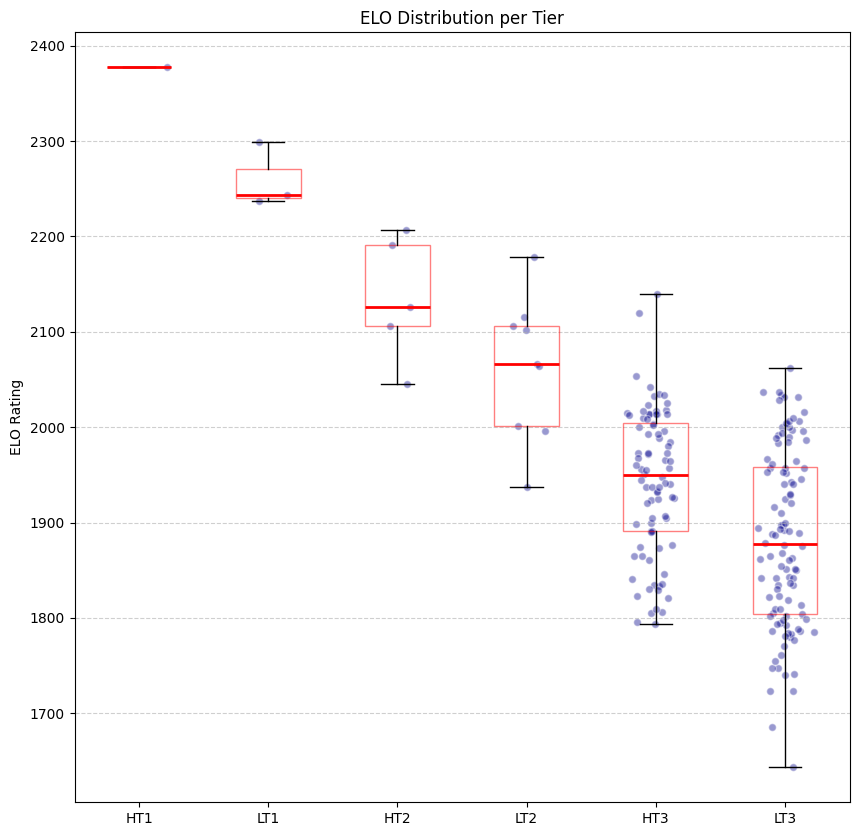

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
positions = np.arange(1, len(tier_data) + 1)

# Boxplot (no fliers)
plt.boxplot(
    tier_data.values(),
    labels=tier_data.keys(),
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="none", color="red", alpha = 0.5),
    medianprops=dict(color="red", linewidth=2),
)

# Overlay individual points
for i, (tier, elos) in enumerate(tier_data.items(), start=1):
    jitter = np.random.normal(0, 0.1, size=len(elos))  # add random horizontal offset
    plt.scatter(
        np.full(len(elos), i) + jitter,
        elos,
        alpha=0.4,
        color="darkblue",
        edgecolor="white",
        s=30,
    )

plt.title("ELO Distribution per Tier")
plt.ylabel("ELO Rating")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

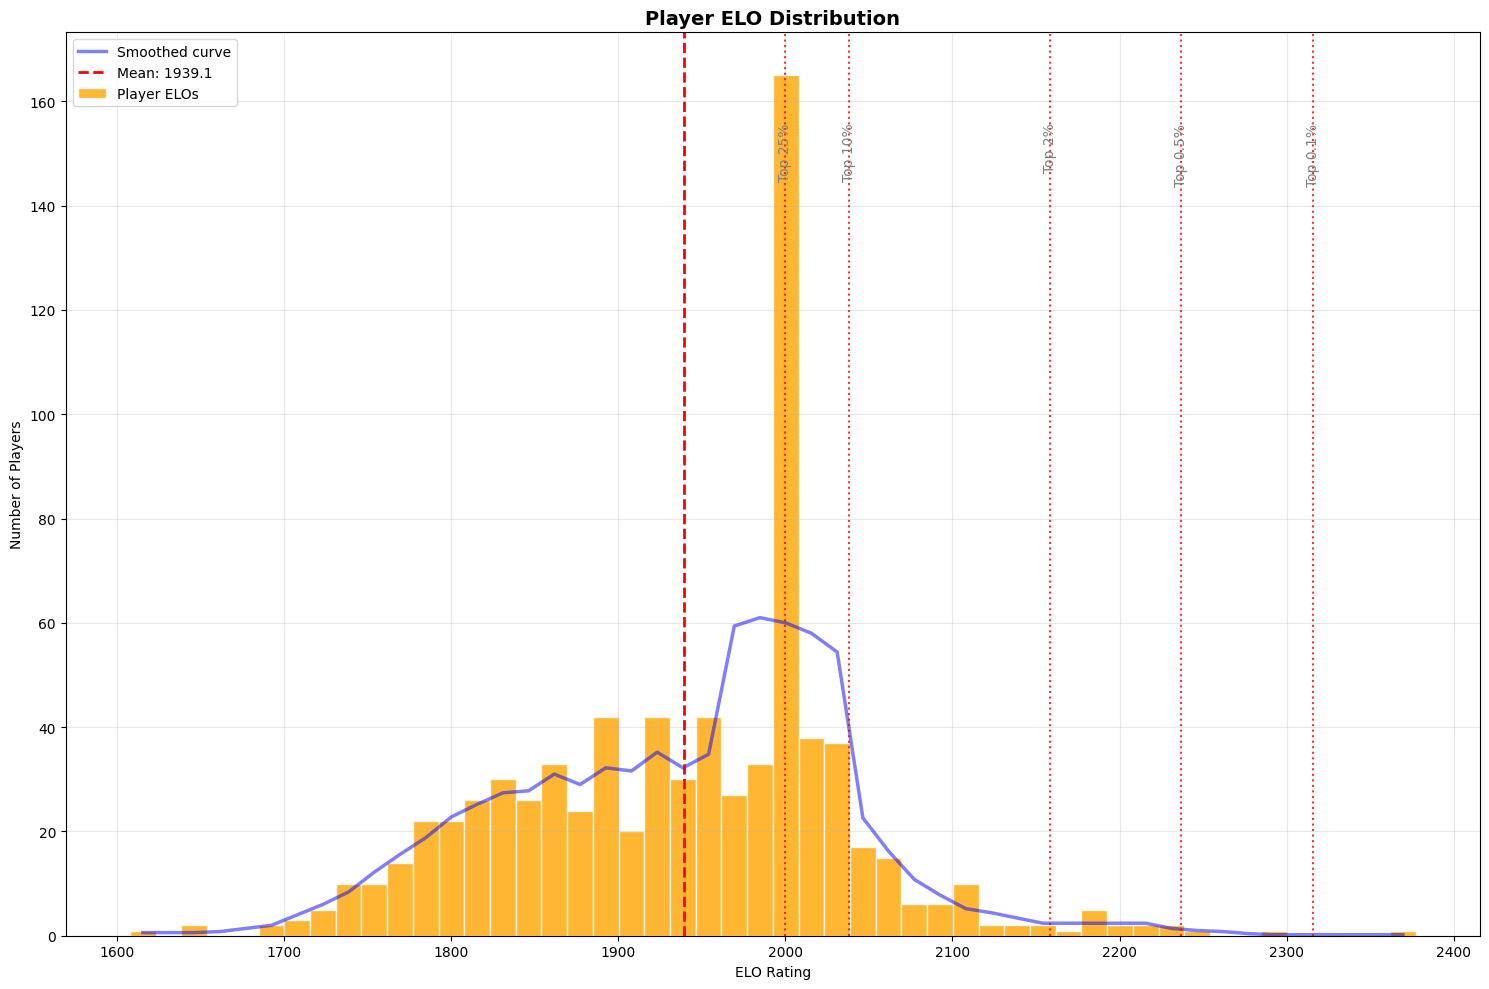

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_elo_distribution(players: dict, bins: int = 40, smooth: bool = True, window: int = 3):
    """
    Plots the ELO distribution of all players with optional smoothing (no SciPy required).

    Args:
        players: dict[str, dict] - player data from process_messages()
        bins: int - number of histogram bins
        smooth: bool - whether to smooth the histogram with a moving average
        window: int - window size for smoothing
    """
    # Collect all ELOs
    elos = np.array([data["elo"] for data in players.values() if "elo" in data])

    if len(elos) == 0:
        print("No ELO data found.")
        return

    # Compute stats
    mean_elo = np.mean(elos)
    median_elo = np.median(elos)


    # Histogram data — now counts, not density
    counts, bin_edges = np.histogram(elos, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Optional smoothing
    if smooth and len(counts) >= window:
        kernel = np.ones(window) / window
        smooth_counts = np.convolve(counts, kernel, mode='same')
    else:
        smooth_counts = counts

    # Plot
    plt.figure(figsize=(15, 10))

    plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]),
            color="orange", alpha=0.8, edgecolor="white", label="Player ELOs")

    if smooth:
        plt.plot(bin_centers, smooth_counts, color="blue", linewidth=2.5, alpha=0.5, label="Smoothed curve")

    # Highlight IQR range
    for i in [75, 90, 98, 99.5, 99.9]:
        t = np.percentile(elos, i)
        plt.axvline(t, color="red", linestyle=":", alpha=0.8)
        plt.text(t, plt.ylim()[1]*0.9, f"Top {round(100-i, 1)}%", rotation=90, va="top", ha="center", fontsize=10, color="gray")

    # Mean and median lines
    plt.axvline(mean_elo, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_elo:.1f}")

    plt.title("Player ELO Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("ELO Rating")
    plt.ylabel("Number of Players")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_elo_distribution(players, bins=50, smooth=True, window=5)


In [61]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta
from collections import defaultdict

def plot_elo_progress(players, sample=None, highlight=None, extend_cutoff_days=200, collapse_daily=True):
    """
    Plots ELO progression for all or selected players.

    Args:
        players: dict of player data (must include "history": list[(datetime, elo)])
        sample: optional list of players to include
        highlight: optional str or list of players to emphasize
        extend_cutoff_days: cutoff for extending line to the latest date
        collapse_daily: if True, keep only the first and last ELO entry per day per player
    """
    plt.figure(figsize=(28, 14))

    # find the latest date overall
    all_dates = [d for p in players.values() for d, _ in p.get("history", [])]
    if not all_dates:
        print("No data to plot.")
        return
    latest_date = max(all_dates)

    # normalize highlight input
    if isinstance(highlight, str):
        highlight = [highlight]
    highlight = set(h.lower() for h in (highlight or []))

    # filter players if sample provided
    if sample:
        selected = {p: players[p] for p in sample if p in players}
    else:
        selected = players

    for name, data in selected.items():
        history = data.get("history", [])
        if not history:
            continue

        history = sorted(history, key=lambda x: x[0])

        # --- Collapse multiple entries on the same day to first + last ---
        if collapse_daily:
            grouped = defaultdict(list)
            for dt, elo in history:
                grouped[dt.date()].append((dt, elo))

            reduced_history = []
            for date, entries in grouped.items():
                entries.sort(key=lambda x: x[0])
                if len(entries) == 1:
                    reduced_history.append(entries[0])
                else:
                    reduced_history.extend([entries[0], entries[-1]])
            history = sorted(reduced_history, key=lambda x: x[0])

        times, elos = zip(*history)
        last_date = times[-1]

        # extend the last elo flat if recent enough
        if latest_date - last_date <= timedelta(days=extend_cutoff_days):
            times = list(times) + [latest_date]
            elos = list(elos) + [elos[-1]]

        name_lower = name.lower()
        if highlight:
            if name_lower in highlight:
                if len(highlight) == 1:
                    plt.plot(times, elos, lw=3.0, alpha=1.0, label=name, color="black", zorder=10)
                else:
                    plt.plot(times, elos, lw=3.0, alpha=1.0, label=name, zorder=10)
            else:
                plt.plot(times, elos, lw=1.2, alpha=0.5, label=name, zorder=1)
        else:
            plt.plot(times, elos, lw=1.2, alpha=1.0, label=name, zorder=1)

    plt.xlabel("Date")
    plt.ylabel("ELO Rating")
    ax = plt.gca()
    ax.yaxis.set_ticks_position('both')   # ticks on left + right
    ax.tick_params(axis='y', labelright=True)  # show labels on right
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%m/%y"))

    # move legend outside, anchored at the top
    # --- Build legend only for top 100 players ---
    top_n = 100
    sorted_players = sorted(players.items(), key=lambda kv: kv[1]["elo"], reverse=True)
    top_players = set(name.lower() for name, _ in sorted_players[:top_n])

    # Filter labels: only keep handles for top 100 names
    handles, labels = plt.gca().get_legend_handles_labels()

    filtered = [
        (h, l) for h, l in zip(handles, labels)
        if l.lower() in top_players
    ]

    if filtered:
        handles, labels = zip(*filtered)
        plt.legend(
            handles,
            labels,
            loc="upper left",
            bbox_to_anchor=(1.02, 1.0),
            fontsize="x-small",
            ncol=1,
            frameon=False,
            title=f"Top {top_n} Players"
        )



    # adjust layout so graph fills the left side nicely
    plt.subplots_adjust(right=0.78, left=0.07, top=0.93, bottom=0.1)
    plt.show()


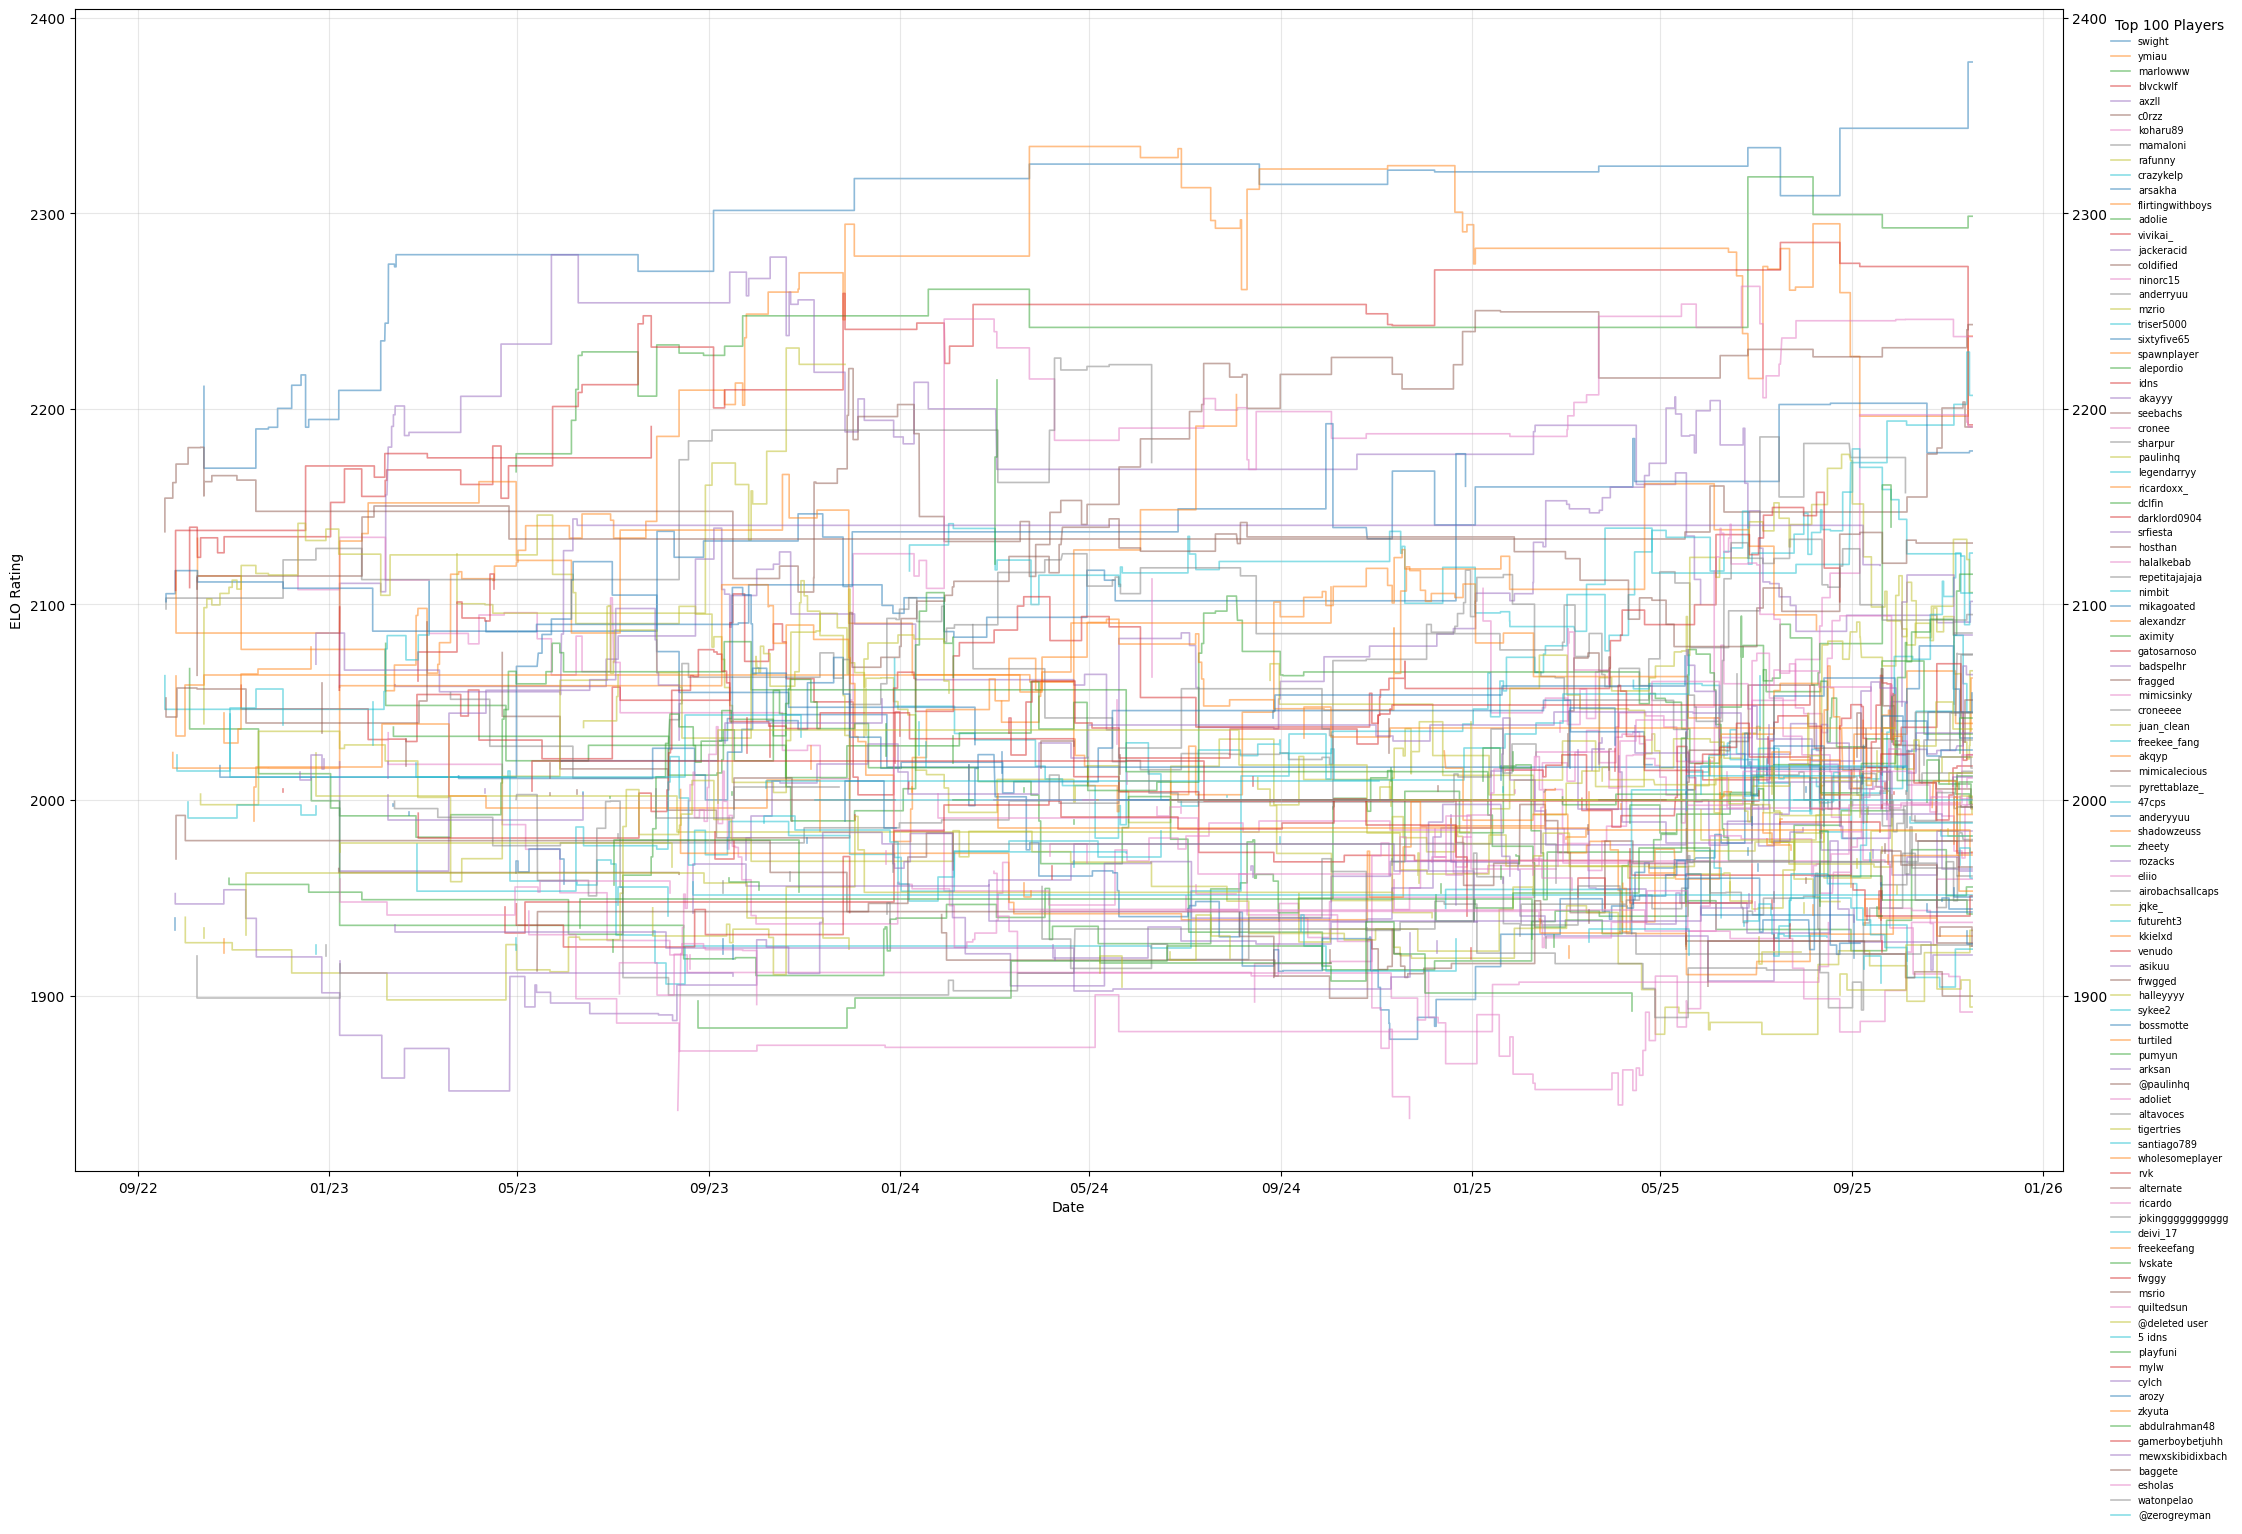

In [62]:
top_n = 500
top_players = sorted(players.items(), key=lambda kv: kv[1]["peak"], reverse=True)[:top_n]

#plot_elo_progress(dict(top_players), sample=["itzrealme", "dreamsan", "marlowww", "crey6712", "camcal", "awerial", "evantii", "wraxps", "gallerywalk"]) # All former HT1s
#plot_elo_progress(dict(top_players), sample=["jaoling", "cowarted", "asteroides", "revcltz", "walksy", "awerial", "2sap", "replaqing", "turrnn", "me_is_lennon", "halalcpvp", "vrzc", "tokenu", "jesprr", "nopzdaflopper", "mystoqn", "vulgular", "lalekz", "daquaviousblm", "quelchi"]) # EU PLAYERS

plot_elo_progress(dict(top_players), highlight=["dagga", "th3bes"], extend_cutoff_days=40)

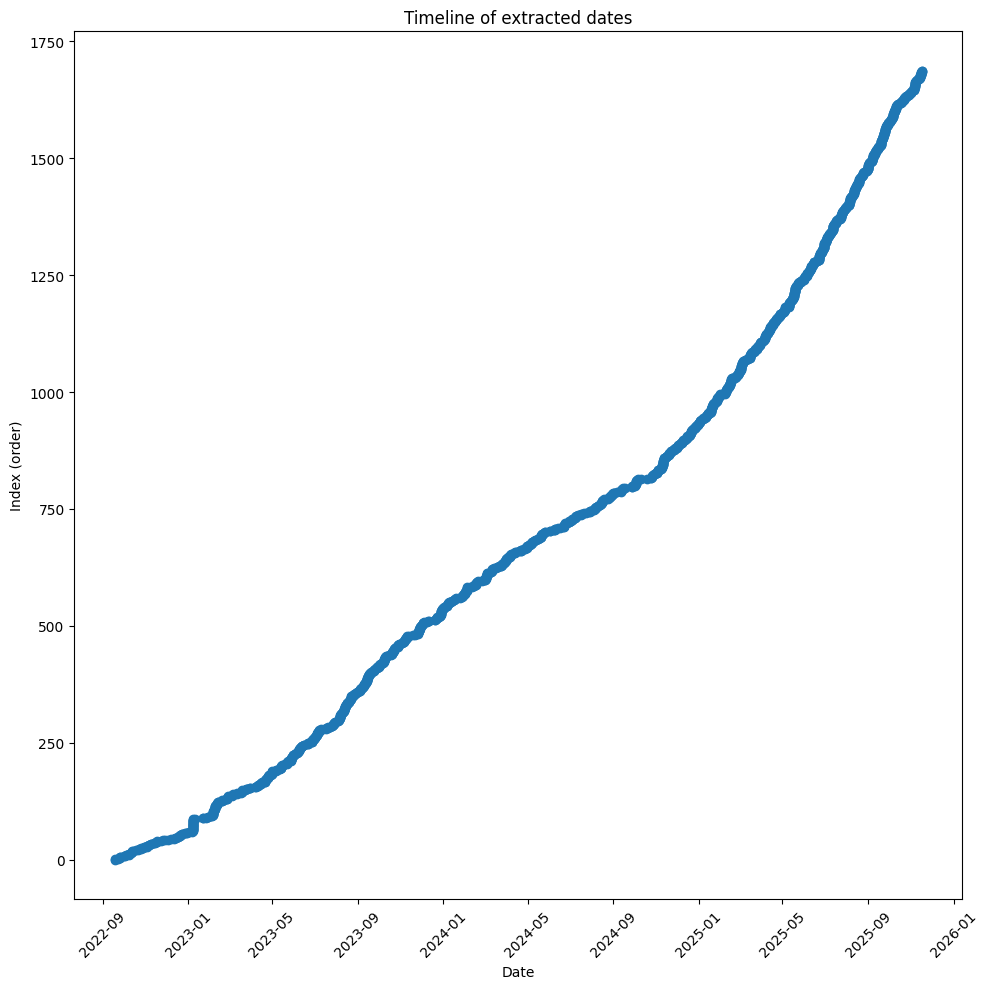

Large gaps found:
From 2022-09-18 18:10:00 to 2022-09-23 02:16:00: 4 days, 8:06:00
From 2022-09-25 17:14:00 to 2022-10-01 02:21:00: 5 days, 9:07:00
From 2022-10-03 20:36:00 to 2022-10-08 15:14:00: 4 days, 18:38:00
From 2022-10-10 20:49:00 to 2022-10-12 23:47:00: 2 days, 2:58:00
From 2022-10-14 20:40:00 to 2022-10-18 01:23:00: 3 days, 4:43:00
From 2022-10-18 01:23:00 to 2022-10-21 17:40:00: 3 days, 16:17:00
From 2022-10-23 06:12:00 to 2022-10-25 17:32:00: 2 days, 11:20:00
From 2022-10-25 21:59:00 to 2022-10-29 00:56:00: 3 days, 2:57:00
From 2022-10-31 02:11:00 to 2022-11-03 02:32:00: 3 days, 0:21:00
From 2022-11-05 19:54:00 to 2022-11-08 17:53:00: 2 days, 21:59:00
From 2022-11-09 15:09:00 to 2022-11-13 17:46:00: 4 days, 2:37:00
From 2022-11-16 21:48:00 to 2022-11-23 06:03:00: 6 days, 8:15:00
From 2022-11-23 06:03:00 to 2022-11-25 09:33:00: 2 days, 3:30:00
From 2022-11-25 09:33:00 to 2022-11-29 02:38:00: 3 days, 17:05:00
From 2022-11-29 02:38:00 to 2022-12-02 14:52:00: 3 days, 12:14:00
F

In [63]:
# FIND LARGE TIME GAPS IN COPY PASTED DATA



import re
from datetime import datetime
import matplotlib.pyplot as plt

# Example long text (replace with your own big string)
text = data

# Step 1: Extract all dates using regex
pattern = r"\d{2}/\d{2}/\d{4}, \d{2}:\d{2}"
matches = re.findall(pattern, text)

# Step 2: Convert to datetime objects
dates = [datetime.strptime(m, "%d/%m/%Y, %H:%M") for m in matches]
dates.sort()  # sort chronologically

# Step 3: Plot the dates
plt.figure(figsize=(10, 10))
plt.plot(dates, range(len(dates)), marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Index (order)")
plt.title("Timeline of extracted dates")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: (Optional) Check for big gaps
gaps = []
for i in range(1, len(dates)):
    delta = dates[i] - dates[i-1]
    if delta.total_seconds() > 3600 * 48:  # bigger than 1 day
        gaps.append((dates[i-1], dates[i], delta))

print("Large gaps found:")
for start, end, delta in gaps:
    print(f"From {start} to {end}: {delta}")
